In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [2]:
import pandas as pd
import numpy as np
import os
from utils import data_loader
import seaborn as sns
import matplotlib.pyplot as plt

from linearmodels.iv import IV2SLS, IVGMM
from linearmodels.iv.results import compare

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [3]:
reduced_terms_list, df_model = data_loader(output_filepath)
df_instruments = pd.read_parquet(output_filepath + 'instrumental_variables.parquet')
instrument_features = list(df_instruments.columns[2:])

df_model_instruments = df_model.merge(df_instruments, on = ['country', 'year'], how = 'left')

Text(0, 0.5, 'cumulative explained variance')

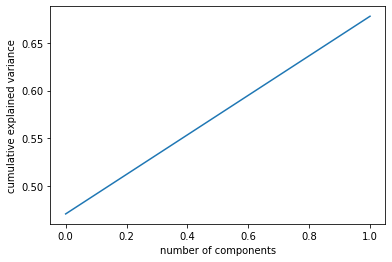

In [4]:
n_endog = 2

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n_endog))]
        )

df_model_instruments[[f'pca_{i}' for i in range(n_endog)]] = pipe.fit_transform(df_model_instruments[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n_endog))]
        )
pipe.fit(df_model_instruments[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [5]:
pca_variables = [f'pca_{i}' for i in range(n_endog)]

res_2sls = IV2SLS(df_model_instruments.log_gdp,  
                 df_model_instruments[["constant", "log_GFCF", "log_wkn_population"]], 
                 df_model_instruments[pca_variables], 
                 df_model_instruments[instrument_features]).fit(
    cov_type="robust", 
)
res_GMM = IVGMM(df_model_instruments.log_gdp, 
                 df_model_instruments[["constant", "log_GFCF", "log_wkn_population"]], 
                 df_model_instruments[pca_variables], 
                 df_model_instruments[instrument_features]).fit(
    cov_type="robust", 
)

res = {}
res["2SLS"] = res_2sls
res["GMM"] = res_GMM

compare(res, precision='std_errors', stars=True,)

,2SLS,GMM
Dep. Variable,log_gdp,log_gdp
Estimator,IV-2SLS,IV-GMM
No. Observations,3806,3806
Cov. Est.,robust,robust
R-squared,0.8457,0.8436
Adj. R-squared,0.8455,0.8434
F-statistic,2.87e+04,9.959e+04
P-value (F-stat),0.0000,0.0000
====================,============,============
constant,-5.1032***,-5.9088***


## PCA instruments

Text(0, 0.5, 'cumulative explained variance')

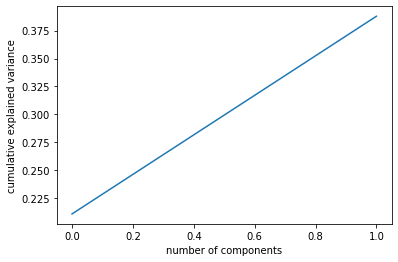

In [6]:
n_instruments = 2

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n_instruments))]
        )

df_model_instruments[[f'instrument_pca_{i}' for i in range(n_instruments)]] = pipe.fit_transform(df_model_instruments[instrument_features].fillna(0))

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n_instruments))]
        )
pipe.fit(df_model_instruments[instrument_features].fillna(0))

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [7]:
pca_variables = [f'pca_{i}' for i in range(n_endog)]
pca_instrument_variables = [f'instrument_pca_{i}' for i in range(n_instruments)]

res_2sls = IV2SLS(df_model_instruments.log_gdp,  
                 df_model_instruments[["constant", "log_GFCF", "log_wkn_population"]], 
                 df_model_instruments[pca_variables], 
                 df_model_instruments[pca_instrument_variables]).fit(
    cov_type="robust", 
)
res_GMM = IVGMM(df_model_instruments.log_gdp, 
                 df_model_instruments[["constant", "log_GFCF", "log_wkn_population"]], 
                 df_model_instruments[pca_variables], 
                 df_model_instruments[pca_instrument_variables]).fit(
    cov_type="robust", 
)

res = {}
res["2SLS"] = res_2sls
res["GMM"] = res_GMM

compare(res, precision='std_errors', stars=True,)

,2SLS,GMM
Dep. Variable,log_gdp,log_gdp
Estimator,IV-2SLS,IV-GMM
No. Observations,3806,3806
Cov. Est.,robust,robust
R-squared,-0.2240,-0.2240
Adj. R-squared,-0.2253,-0.2253
F-statistic,2447.8,2447.8
P-value (F-stat),0.0000,0.0000
====================,============,============
constant,-16.357***,-16.357***


In [8]:
res_GMM.first_stage

,pca_0,pca_1
R-squared,0.2187,0.1705
Partial R-squared,0.0119,0.0154
Shea's R-squared,0.0048,0.0062
Partial F-statistic,48.570,227.42
P-value (Partial F-stat),2.84e-11,0.0000
Partial F-stat Distn,chi2(2),chi2(2)
==========================,===========,===========
constant,-6.3777,3.4844
,(-18.511),(15.361)
log_GFCF,0.4078,0.0934


In [9]:
res_GMM.j_stat

H0: Expected moment conditions are equal to 0
Statistic: 0.0000
P-value: nan
Distributed: chi2(0)
WaldTestStatistic, id: 0x7fd6cc555c90